In [1]:
print('Importing libraries...')
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime, timedelta
import time
import tempfile

Importing libraries...


In [2]:
print('begin the process..')
start_time = time.time()

begin the process..


In [3]:
print('Setting up data generator...')
train_dir = '../../data_v1_adjusted/train'
valid_dir = '../../data_v1_adjusted/val'
test_dir = '../../data_v1_adjusted/test'

BATCH_SIZE = 64
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.0003
initial_epochs = 1
fine_tune_epochs = 1
pred_thresholds = 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
fine_tune_at = 100
drop_out = 0.8

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
train_labels = tf.concat([y for x, y in train_dataset], axis=0)

validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
valid_labels = tf.concat([y for x, y in validation_dataset], axis=0)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)
test_labels = tf.concat([y for x, y in test_dataset], axis=0)

classes = train_dataset.class_names

Setting up data generator...
Found 8431 files belonging to 5 classes.
Found 1052 files belonging to 5 classes.
Found 1060 files belonging to 5 classes.


In [4]:
print('configuring data training performance...')
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

configuring data training performance...


In [5]:
print('preparing and building the model...')
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

# preprocess_input = tf.keras.applications.vgg16.preprocess_input
# base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')


data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomFlip('vertical'),
                                         tf.keras.layers.RandomRotation(0.2)])
    
# top_layer = [preprocess_input, base_model]

preparing and building the model...


In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [7]:
def get_transfer_model(output_bias):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    base_model.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = preprocess_input(inputs)
    x = data_augmentation(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(classes),
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_initializer=output_bias)(x) 
                                    # activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [15]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="-.", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])
    plt.legend();

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Face Detected (True Negatives): ', cm[0][0])
    print('Legitimate Face Incorrectly Detected (False Positives): ', cm[0][1])
    print('Spoof Attack Missed (False Negatives): ', cm[1][0])
    print('Spoof Attack Detected (True Positives): ', cm[1][1])
    print()
    print('Total Spoof Attack: ', np.sum(cm[1]))
    print('Total Real Face: ', np.sum(cm[0]))

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5])
    plt.ylim([-0.5,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

begin the transfer learning...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                              

Epoch 48/500
132/132 [==============================] - 26s 194ms/step - loss: 0.4058 - accuracy: 0.8530 - val_loss: 0.3626 - val_accuracy: 0.8707
Epoch 49/500
132/132 [==============================] - 26s 193ms/step - loss: 0.4081 - accuracy: 0.8497 - val_loss: 0.3661 - val_accuracy: 0.8669
Epoch 50/500
132/132 [==============================] - 24s 183ms/step - loss: 0.4067 - accuracy: 0.8482 - val_loss: 0.3591 - val_accuracy: 0.8698
Epoch 51/500
132/132 [==============================] - 25s 191ms/step - loss: 0.4107 - accuracy: 0.8494 - val_loss: 0.3589 - val_accuracy: 0.8698
Epoch 52/500
132/132 [==============================] - 24s 182ms/step - loss: 0.4066 - accuracy: 0.8511 - val_loss: 0.3568 - val_accuracy: 0.8660
Epoch 53/500
132/132 [==============================] - 26s 192ms/step - loss: 0.4082 - accuracy: 0.8458 - val_loss: 0.3573 - val_accuracy: 0.8669
Epoch 54/500
132/132 [==============================] - 26s 194ms/step - loss: 0.4067 - accuracy: 0.8513 - val_loss: 0

Epoch 104/500
132/132 [==============================] - 26s 192ms/step - loss: 0.3859 - accuracy: 0.8603 - val_loss: 0.3426 - val_accuracy: 0.8783
Epoch 105/500
132/132 [==============================] - 25s 191ms/step - loss: 0.3847 - accuracy: 0.8594 - val_loss: 0.3428 - val_accuracy: 0.8764
Epoch 105: early stopping
17/17 [==============================] - 4s 203ms/step - loss: 0.3940 - accuracy: 0.8415


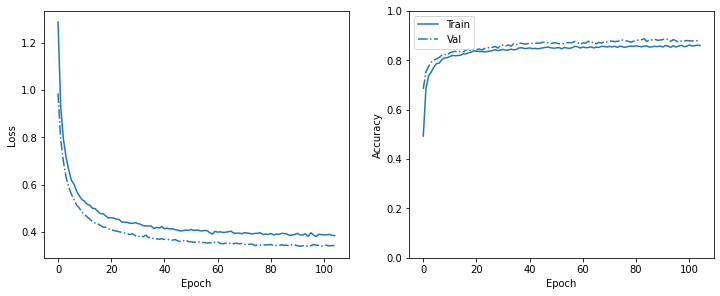

In [9]:
print('begin the transfer learning...')
m1 = get_transfer_model(output_bias=None)
# m2.load_weights(initial_weights)
m1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history_m1 = m1.fit(train_dataset,
                    epochs=500,
                    validation_data=validation_dataset, 
                    callbacks=[early_stopping]
                   )
m1.evaluate(test_dataset)
plot_metrics(history_m1)

In [27]:
train_predictions_baseline = tf.math.argmax(tf.nn.softmax(m1.predict(train_dataset, batch_size=BATCH_SIZE)), axis=1)
valid_predictions_baseline = tf.math.argmax(tf.nn.softmax(m1.predict(validation_dataset, batch_size=BATCH_SIZE)), axis=1)
test_predictions_baseline = tf.math.argmax(tf.nn.softmax(m1.predict(test_dataset, batch_size=BATCH_SIZE)), axis=1)

Legitimate Face Detected (True Negatives):  24
Legitimate Face Incorrectly Detected (False Positives):  22
Spoof Attack Missed (False Negatives):  22
Spoof Attack Detected (True Positives):  26

Total Spoof Attack:  157
Total Real Face:  161


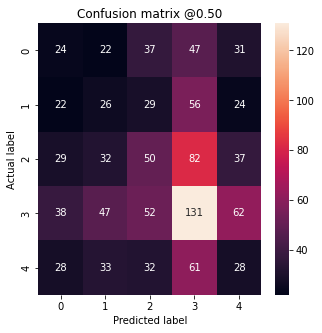

In [28]:
plot_cm(test_labels, test_predictions_baseline)

In [29]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

ValueError: multiclass format is not supported